# Figures for AIRS PAN paper

## Imports

In [125]:
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter, LatitudeLocator
import cmasher as cmr
from copy import deepcopy
from pyhdf import SD
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.lines import Line2D
import metpy # needed to activate accessors in xarray
from netCDF4 import Dataset
import numpy as np
import pandas as pd
from pathlib import Path
import pyhdf
from scipy.interpolate import interp1d
from scipy.stats import pearsonr
import shap
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
from tqdm import tqdm
import xarray as xr

import jllutils.plots as jplt
import jllutils.geography as jgeo
import jllutils.stats as jstats
from muses_utils import quick_plots, quality, readers, images, plots, conversions

from airs_pan_ml import features, readers as aread
from airs_pan_ml.binary_flag import metrics, training
from airs_pan_ml import plots as aplt

## Helper functions

In [2]:
def plot_box(west_lon, east_lon, north_lat, south_lat, ax, **style):
    x = [west_lon, east_lon, east_lon, west_lon, west_lon]
    y = [north_lat, north_lat, south_lat, south_lat, north_lat]
    style.setdefault('transform', ccrs.PlateCarree())
    ax.plot(x, y, **style)

def make_airs_filterer(*extra_filters, include_h2o=True, airs_filter='deriv'):
    filterer = quality.StdPanFilter('OSP-AIRS-v9-PAN', 'laughner', add_airs_filter=airs_filter)
    filterer.add_filterer(quality.VariableQualityFilterer('radianceResidualRMS', 0.5, 2))
    filterer.add_filterer(quality.VariableQualityFilterer('radianceResidualMean', -0.5, 0.5))
    if include_h2o:
        filterer.add_filterer(quality.StdFlagQualityFilterer('Quality', alternate_step='H2O-1'))
    for f in extra_filters:
        filterer.add_filterer(f)
    return filterer

## Microwindows

In [108]:
AIRS_WINDOWS = [(772.5, 775), (780, 781.875), (793.75, 796.875), (800, 802.5), (804.375, 805)]
CRIS_WINDOWS = [(780, 783.125), (786.25, 790.625)]


def plot_microwindow_selection(fm_pantest_file, perturbation_file):
    pretty_gas = {'PAN': 'PAN', 'O3': 'O$_3$', 'CO2': 'CO$_2$', 'H2O': 'H$_2$O', 'CCL4': 'CCl$_4$'}
    ngas = len(pretty_gas)
    _, axs = plt.subplots(ngas, 1, figsize=(12, 1.4*ngas), sharex=True)

    with Dataset(fm_pantest_file) as ds:
        airs_chan_freq = ds['FREQUENCY'][0]
        airs_chan_nesr = ds['NESR'][0]
        airs_chan_freq = airs_chan_freq[airs_chan_nesr > 0]

    airs_windows = AIRS_WINDOWS
    cris_windows = CRIS_WINDOWS

    with Dataset(perturbation_file) as ds:
        freq = ds['frequency'][:].filled(np.nan)
        for ax, (gas_name, gas_label) in zip(axs, pretty_gas.items()):
            delta_bt = ds[f'{gas_name.lower()}_delta_brightness_temperature'][:].filled(np.nan)
            _plot_radiance_perturbation(freq, delta_bt, ax=ax, channels=airs_chan_freq, color='black')
            h_aw = _plot_windows(airs_windows, ax=ax, color='tab:blue', label='AIRS Windows')
            h_cw = _plot_windows(cris_windows, ax=ax, color='tab:orange', half='very-top', label='CrIS Windows')
            ax.text(0.98, 0.05, gas_label, transform=ax.transAxes, ha='right', fontsize=16)
            ax.set_xlim(770, 830)
            ax.set_xticks(np.arange(770, 831, 5)) 
            ax.set_ylabel(r'$\Delta$ BT (K)')
            ax.grid(True, axis='x')
    handles = [
        Line2D([0], [0], color='k', label='Spectrum'),
        Line2D([0], [0], marker='.', color='gray', ls='none', label='AIRS Channels'),
        h_aw,
        h_cw
    ]
    axs[0].legend(handles=handles, loc='lower center', bbox_to_anchor=(0.5, 1.01), ncol=5)
    axs[-1].set_xlabel('Frequency (cm$^{-1}$)')
        


def _plot_radiance_perturbation(freq, delta_bt, ax=None, channels=None, **style):
    ax = ax or plt.gca()
    ax.plot(freq, delta_bt, **style)
    if channels is not None:
        y = np.full(channels.size, np.nanmax(np.abs(delta_bt))*0.1)
        ax.plot(channels, y, marker='.', color='gray', ls='none')
        
        
def _plot_windows(windows, ax=None, half=None, **style):
    ax = ax or plt.gca()
    y1, y2 = ax.get_ylim()
    ax.set_ylim(y1, y2)
    if half == 'bottom':
        y2 = y1 + 0.5*(y2-y1)
    elif half == 'top':
        y1 = y1 + 0.5*(y2-y1)
    elif half == 'very-top':
        y1 = y1 + 0.8*(y2-y1)
    elif half == 'top-offset':
        y2 = y1 + 0.8*(y2-y1)
    elif half == 'bottom-offset':
        y1 = y1 + 0.2*(y2-y1)
    style.setdefault('alpha', 0.5)
    style.setdefault('color', 'tab:blue')
    for x1, x2 in windows:
        p = ax.fill_betweenx([y1,y2], x1, x2, **style)
    return p

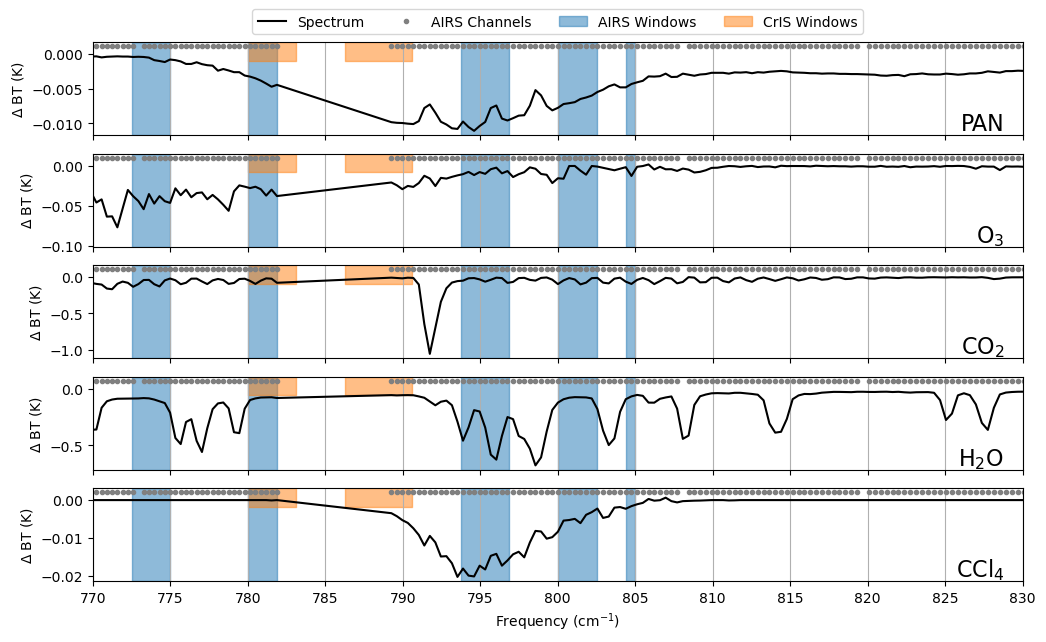

In [319]:
plot_microwindow_selection(
    fm_pantest_file='../static-data/validation/airs-runs/airs/2020-09-11/combine/West_Coast_Fires_Pacific/Products_Radiance-FM-pantest.nc',
    perturbation_file='extra-data/spectral-signatures.nc',
)
plt.savefig('img/window_selection.pdf', bbox_inches='tight')

## West Coast & Australia Fires - Cloud filtering

In [4]:
cloud_box = [-142, -122, 30, 20]
aus_cloud_box = [171.5, 178.5, -46.5, -61.0]

### Early filter tests

Reading quality flag file /home/laughner/OSP/Strategy_Tables/laughner/OSP-AIRS-v9-PAN/QualityFlags/QualityFlag_Spec_Nadir_PAN.asc


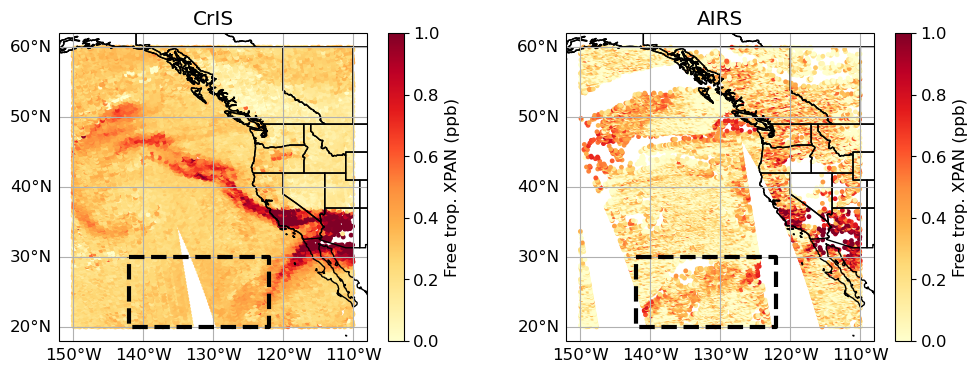

In [71]:
with plt.rc_context({'font.size': 12}):
    _, axs = plt.subplots(1,2,figsize=(12,4),subplot_kw={'projection': ccrs.PlateCarree()})

    ax = axs[0]
    cris_qual_filter = quality.StdFlagQualityFilterer('Quality')
    quick_plots.plot_sounding_map_from_combined(
        combined_file='../static-data/validation/airs-runs/cris/2020-09-11/combine/West_Coast_Fires_Pacific/Lite_Products_L2-PAN-0.nc',
        variable='Retrieval/XPAN800',
        map_features=[cfeat.COASTLINE, cfeat.STATES],
        bias_corr=quality.CrisXpanBiasCorr(),
        filterer=cris_qual_filter,
        vmax=1,
        cblabel='Free trop. XPAN (ppb)',
        cmap='YlOrRd',
        ax=ax
    )
    plot_box(*cloud_box, ax=ax, color='k', ls='--', lw=3)
    ax.set_title('CrIS')

    ax = axs[1]
    basic_plus_h2o_airs_filter = make_airs_filterer(include_h2o=True, airs_filter=None)
    quick_plots.plot_sounding_map_from_combined(
        '../static-data/validation/airs-runs/airs/2020-09-11/combine/West_Coast_Fires_Pacific/Lite_Products_L2-PAN-0.nc',
        variable='Retrieval/XPAN800',
        map_features=[cfeat.COASTLINE, cfeat.STATES],
        filterer=basic_plus_h2o_airs_filter,
        ax=ax,
        cblabel='Free trop. XPAN (ppb)',
        cmap='YlOrRd',
        vmax=1
    )

    plot_box(*cloud_box, ax=ax, color='k', ls='--', lw=3)
    ax.set_title('AIRS')
    plt.savefig('img/wcf-spurious-plume.png', bbox_inches='tight')
    plt.savefig('img/wcf-spurious-plume.pdf', bbox_inches='tight')

### Cloud properties

In [6]:
def plot_wcf_modis(modis_data, vars_to_plot=None, nx=2, modis_cblabels=dict(), invert_colorbar_for=tuple(), variable_plot_kws=dict(), panel_size=(8,6), axs=None, **modis_plot_kws):
    if vars_to_plot is None:
        vars_to_plot = [k for k in modis_data if k not in {'Latitude', 'Longitude', 'Latitude_1km', 'Longitude_1km'}]
        
    nplots = len(vars_to_plot)
    if axs is None:
        sp = jplt.Subplots(nplots, nx=nx, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=panel_size)
        axs = [sp.next_subplot() for _ in vars_to_plot]
    elif len(axs) != len(vars_to_plot):
        raise ValueError('Number of axes given must match the number of variables to plot')
        
    for ax, varname in zip(axs, vars_to_plot):
        xx_fills = modis_data[varname] < 0
        kws = modis_plot_kws.copy()
        kws.update(variable_plot_kws.get(varname, dict()))
        h = ax.scatter(modis_data['Longitude'][~xx_fills], modis_data['Latitude'][~xx_fills], c=modis_data[varname][~xx_fills], **kws)
        
        cblabel = modis_cblabels.get(varname, varname.replace('_', ' '))
        cb = plt.colorbar(h, ax=ax, label=cblabel)
        if varname in invert_colorbar_for:
            cb.ax.invert_yaxis()
        gl = ax.gridlines(draw_labels=True)
        gl.top_labels=False
        gl.right_labels=False

        ax.coastlines()
        ax.add_feature(cfeat.STATES)
        ax.add_feature(cfeat.LAND)
        ax.add_feature(cfeat.OCEAN)
    
    return axs
    
    
    
def load_modis_data(modis_files, datasets):
    sd_handles = [SD.SD(mf) for mf in modis_files]
    data_arrays = {n: _load_modis_sds(sd_handles, n) for n in datasets}
    return data_arrays


def load_modis_coords(myd06_files, infer_1km=True):
    def find_myd03(f6):
        f6 = Path(f6)
        # Assume MYD06 file = MYD06_L2.A2004200.1555.061.2018015111612.hdf
        # and MYD03 file = MYD03.A2004200.1555.061.2018014232916.hdf
        # so get the 2nd, 3rd, and 4th parts (separated by '.')
        date, time, vers = f6.name.split('.')[1:4]
        f3pattern = f'MYD03.{date}.{time}.{vers}.*.hdf'
        f3 = list(f6.parent.glob(f3pattern))
        if len(f3) == 1:
            return str(f3[0])
        else:
            raise IOError(f'Could not find MYD03 file matching {f3pattern} in {f6.parent}')
            
    latlon = load_modis_data(myd06_files, ['Latitude', 'Longitude'])
    if infer_1km:
        myd03_files = [find_myd03(f) for f in myd06_files]
        latlon_1km = {f'{k}_1km': v for k, v in load_modis_data(myd03_files, ['Latitude', 'Longitude']).items()}
        latlon.update(latlon_1km)
        
    return latlon
    
    
def _load_modis_sds(handles, dset_name):
    all_data = []
    for h in handles:
        sds = h.select(dset_name)
        data = sds[:]
        if hasattr(sds, 'add_offset'):
            data = data - sds.add_offset
        if hasattr(sds, 'scale_factor'):
            data = data * sds.scale_factor
        
        if np.issubdtype(data.dtype, np.floating):
            data = np.ma.masked_where(np.isclose(data, sds._FillValue), data)
        else:
            data = np.ma.masked_where(data == sds._FillValue, data)
            
        all_data.append(data)
        
    all_data = np.ma.concatenate(all_data, axis=0)

    return all_data

In [7]:
goes_wcf_file = 'extra-data/goes-abi/OR_ABI-L2-MCMIPC-M6_G17_s20202552211176_e20202552213561_c20202552214089.nc'
wcf_img = images.GoesImageProvider.from_abi_file(goes_wcf_file)
cris_clear_goes_wcf_file = 'extra-data/goes-abi/OR_ABI-L2-MCMIPC-M6_G17_s20202552111176_e20202552113560_c20202552114084.nc'
cris_clear_goes_wcf_img = images.GoesImageProvider.from_abi_file(cris_clear_goes_wcf_file)
cris_cloudy_goes_wcf_file = 'extra-data/goes-abi/OR_ABI-L2-MCMIPC-M6_G17_s20202552246176_e20202552248560_c20202552249084.nc'
cris_cloudy_goes_wcf_img = images.GoesImageProvider.from_abi_file(cris_cloudy_goes_wcf_file)

In [8]:
wcf_files = ['extra-data/modis-clouds/MYD06_L2.A2020255.2210.061.2020258150535.hdf', 'extra-data/modis-clouds/MYD06_L2.A2020255.2215.061.2020258150531.hdf']
wcf_modis = load_modis_coords(wcf_files)
tmp = load_modis_data(wcf_files, ['Cloud_Fraction', 'Cloud_Top_Pressure', 'Cloud_Top_Temperature'])
wcf_modis.update(tmp)

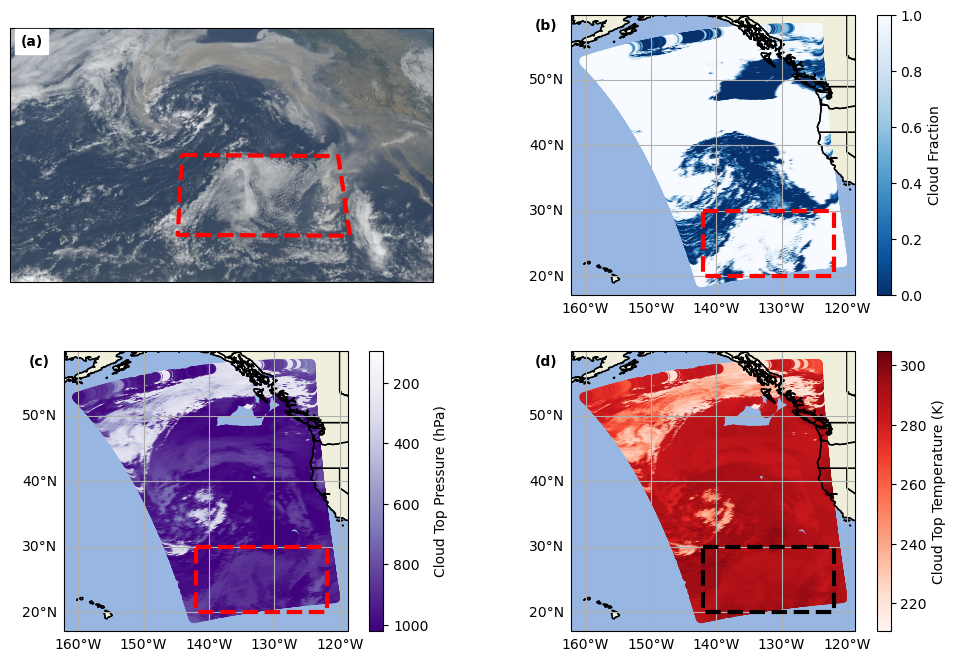

In [73]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(2, 2, 1 ,projection=wcf_img._proj)
wcf_img.add_image(ax)
plot_box(*cloud_box, ax=ax, color='r', ls='--', lw=3)
ax.text(0.025, 0.975, '(a)', va='top', transform=ax.transAxes, fontweight='bold', backgroundcolor='white')

modis_axs = [fig.add_subplot(2, 2, i, projection=ccrs.PlateCarree()) for i in range(2,5)]
plot_wcf_modis(
    wcf_modis,
    modis_cblabels={'Cloud_Top_Pressure': 'Cloud Top Pressure (hPa)', 'Cloud_Top_Temperature': 'Cloud Top Temperature (K)', 'Cloud_Fraction': 'Cloud Fraction'},
    invert_colorbar_for=['Cloud_Top_Pressure'],
    variable_plot_kws={'Cloud_Top_Pressure': {'cmap': 'Purples'}, 'Cloud_Top_Temperature': {'cmap': 'Reds'}, 'Cloud_Fraction': {'cmap': 'Blues_r', 'vmin': 0, 'vmax': 1.0}},
    axs=modis_axs
)

for ax in modis_axs[:-1]:
    plot_box(*cloud_box, ax, ls='--', lw=3, color='red')
plot_box(*cloud_box, modis_axs[-1], ls='--', lw=3, color='k')

jplt.label_subplots(modis_axs, seq='bcd', xpos=-0.05)
plt.savefig('img/wcf-cloud-properties.png', bbox_inches='tight')
plt.savefig('img/wcf-cloud-properties.pdf', bbox_inches='tight')

### EOF method

In [9]:
def fit_pca_for_plots(wcf_file='../static-data/validation/airs-runs/airs/2020-09-11/combine/West_Coast_Fires_Pacific/Products_Radiance-FM-pantest.nc'):
    with Dataset(wcf_file) as ds:
        data = dict(
            lon=readers.get_nc_var(ds, 'LONGITUDE'),
            lat=readers.get_nc_var(ds, 'LATITUDE'),
            freq=readers.get_nc_var(ds, 'FREQUENCY')[0],
            rad=readers.get_nc_var(ds, 'RADIANCEOBSERVED')
        )
        data['rad'] = conversions.bt(data['freq'], data['rad'])
        data = _clean_rad_data(data)
        
    pca = PCA()
    data['transform'] = pca.fit_transform(data['rad'])
    data['pca'] = pca
    return data


def plot_pca_coefficients(pca_data, component_inds=(0,1,2), axs=None):
    if axs is None:
        nx = len(component_inds)
        _, axs = plt.subplots(1, nx, figsize=(6*nx, 4), subplot_kw={'projection': ccrs.PlateCarree()})
        if nx == 1:
            axs = [axs]
        
    for ind, ax in zip(component_inds, axs):
        h = ax.scatter(pca_data['lon'], pca_data['lat'], c=pca_data['transform'][:,ind], cmap='nipy_spectral')
        plt.colorbar(h, ax=ax, label=f'PCA coeff #{ind+1}')
        ax.add_feature(cfeat.STATES, linewidth=0.5)
        ax.coastlines()
        gl = ax.gridlines(draw_labels=True)
        gl.top_labels = False
        gl.right_labels = False

    return axs


def _clean_rad_data(rad_data):
    """Clean up data for PCA
    
    Removes spectra that contain NaNs and frequencies that contain near-0 values.
    Returns a dictionary with the same structure as the input, but with the data
    cut down in this way.
    """
    xx = ~np.any(np.isnan(rad_data['rad']), axis=1)
    yy = ~np.any(rad_data['rad'][xx] < 1, axis=0)
    rad_data_clean = {k: v[xx] for k, v in rad_data.items() if k != 'freq'}
    rad_data_clean['freq'] = rad_data['freq'][yy]
    rad_data_clean['rad'] = rad_data_clean['rad'][:,yy]
    return rad_data_clean

In [10]:
def plot_pca_components(pca_info, component_inds=(0,1,2), ax=None, **style):
    ax = ax or plt.gca()
    if isinstance(pca_info, dict):
        freq = pca_info['freq']
        components = pca_info['pca'].components_
        frac_var = pca_info['pca'].explained_variance_ratio_ * 100
    else:
        with Dataset(pca_info) as ds:
            freq = ds['frequency'][:]
            components = ds['components'][:]
            frac_var = ds['explained_variance_ratio'][:] * 100
        
    for i in component_inds:
        norm = np.nanmax(np.abs(components[i]))
        style.setdefault('label', f'#{i+1}, EV = {frac_var[i]:.2f}%')
        ax.plot(freq, components[i] / norm, **style)
    ax.legend()
    ax.set_xlabel('Frequency (cm$^{-1}$)')
    ax.set_ylabel('Normalize brightness temperature')
    ax.grid(True)
    
    
def plot_pca_components_sep_axes(pca_info, component_inds=(0,1,2), legend_loc=None, spectral_signature_file='extra-data/spectral-signatures.nc'):
    cm = plt.get_cmap('tab10')
    ny = len(component_inds)
    if spectral_signature_file is not None:
        _, all_axs = plt.subplots(ny+1, 1, figsize=(12, 2*(ny+1)), sharex=True, sharey=True)
        axs = all_axs[1:]
    else:
        _, axs = plt.subplots(ny, 1, figsize=(12, 2*ny), sharex=True, sharey=True)
        
    for col_ind, (comp_ind, ax) in enumerate(zip(component_inds, axs)):
        color = cm(col_ind)
        plot_pca_components(pca_info, component_inds=[comp_ind], ax=ax, color=color)
        if col_ind != ny // 2:
            ax.set_ylabel('')
        if col_ind != ny - 1:
            ax.set_xlabel('')
        if legend_loc:
            ax.legend(loc=legend_loc)

    if spectral_signature_file is not None:
        with Dataset(spectral_signature_file) as ds:
            freq = ds['frequency'][:].filled(np.nan)
            pan_bt = ds['pan_delta_brightness_temperature'][:].filled(np.nan)
            h2o_bt = ds['h2o_delta_brightness_temperature'][:].filled(np.nan)
        ax = all_axs[0]
        _, _, ax2 = jplt.create_twin_axes_with_color(color2='gray', ax=ax)
        ax2.plot(freq, pan_bt, color='gray')
        ax.plot(freq, h2o_bt, color='black')
        handles = [
            Line2D([0], [0], color='gray', label='PAN'),
            Line2D([0], [0], color='black', label='H$_2$O'),
        ]
        ax.legend(handles=handles, loc='lower right', ncol=2)
        ax.grid(True)
        ax.set_ylabel('H$_2$O spectral sig. (K)')
        ax2.set_ylabel('PAN spectral sig. (K)')

In [75]:
wcf_pca_data = fit_pca_for_plots()

/project/lt_ref17/laughner/notebooks/pan-camel/src/muses_utils/muses_utils/conversions.py:47: RuntimeWarning: divide by zero encountered in true_divide
  bt = RADCN2 * frequency / np.log(1 + (RADCN1 * frequency**3 / rad))


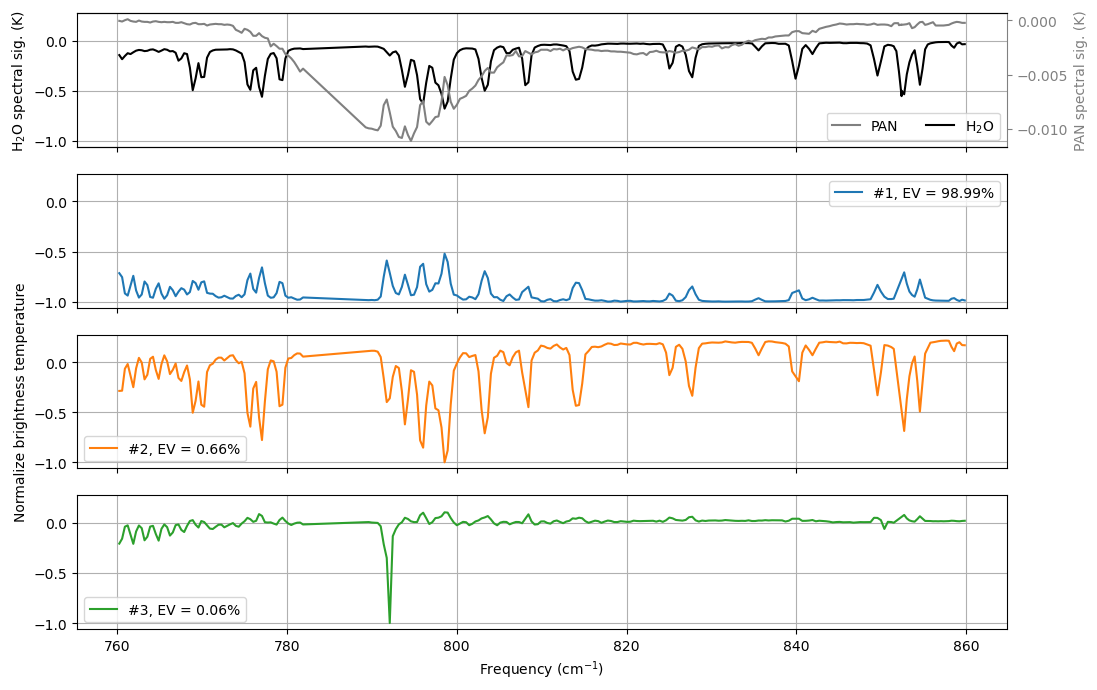

In [36]:
plot_pca_components_sep_axes(wcf_pca_data)
plt.savefig('img/wcf-radiance-eofs.pdf', bbox_inches='tight')

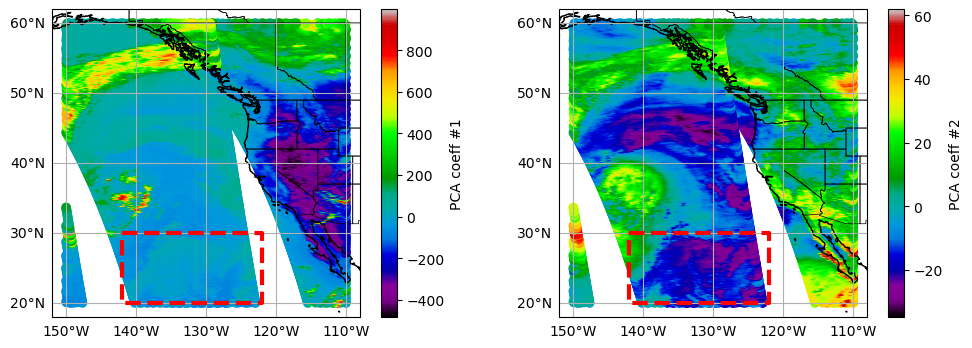

In [76]:
axs = plot_pca_coefficients(wcf_pca_data, component_inds=(0,1))
for ax in axs:
    plot_box(*cloud_box, ax, ls='--', lw=3, color='r')
plt.savefig('img/wcf-rad-pcs.png', bbox_inches='tight')
plt.savefig('img/wcf-rad-pcs.pdf', bbox_inches='tight')

Reading quality flag file /home/laughner/OSP/Strategy_Tables/laughner/OSP-AIRS-v9-PAN/QualityFlags/QualityFlag_Spec_Nadir_PAN.asc
Loading PCA fits from cache


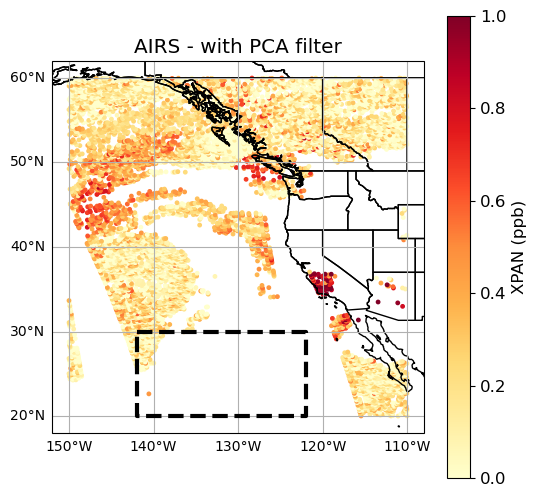

In [77]:
with plt.rc_context({'font.size': 12}):
    ax = jplt.quick_axes(figsize=(6,6), projection=ccrs.PlateCarree())
    airs_qual_filter_withpca = make_airs_filterer(quality.PCALowCloudPANFilterer(), include_h2o=False)
    quick_plots.plot_sounding_map_from_combined(
        '../static-data/validation/airs-runs/airs/2020-09-11/combine/West_Coast_Fires_Pacific/Lite_Products_L2-PAN-0.nc',
        variable='Retrieval/XPAN800',
        map_features=[cfeat.STATES, cfeat.COASTLINE],
        filterer=airs_qual_filter_withpca,
        ax=ax,
        cblabel='XPAN (ppb)',
        cmap='YlOrRd',
        vmax=1
    )

    plot_box(*cloud_box, ax=ax, color='k', ls='--', lw=3)
    ax.set_title('AIRS - with PCA filter')
    

In [11]:
aus_modis_files = sorted(p.as_posix() for p in Path('extra-data/modis-clouds/').glob('MYD??_L2.A2020001*.hdf'))
aus_modis_data = load_modis_data(aus_modis_files, ['Longitude', 'Latitude', 'Cloud_Fraction', 'Cloud_Top_Pressure', 'Cloud_Top_Temperature'])
aus_modis_data['Cloud_Top_Pressure'] = np.ma.masked_less(aus_modis_data['Cloud_Top_Pressure'], 0)
aus_modis_data['Cloud_Top_Temperature'] = np.ma.masked_less(aus_modis_data['Cloud_Top_Temperature'], 0)

Reading quality flag file /home/laughner/OSP/Strategy_Tables/laughner/OSP-AIRS-v9-PAN/QualityFlags/QualityFlag_Spec_Nadir_PAN.asc
Loading PCA fits from cache
Loading PCA fits from cache


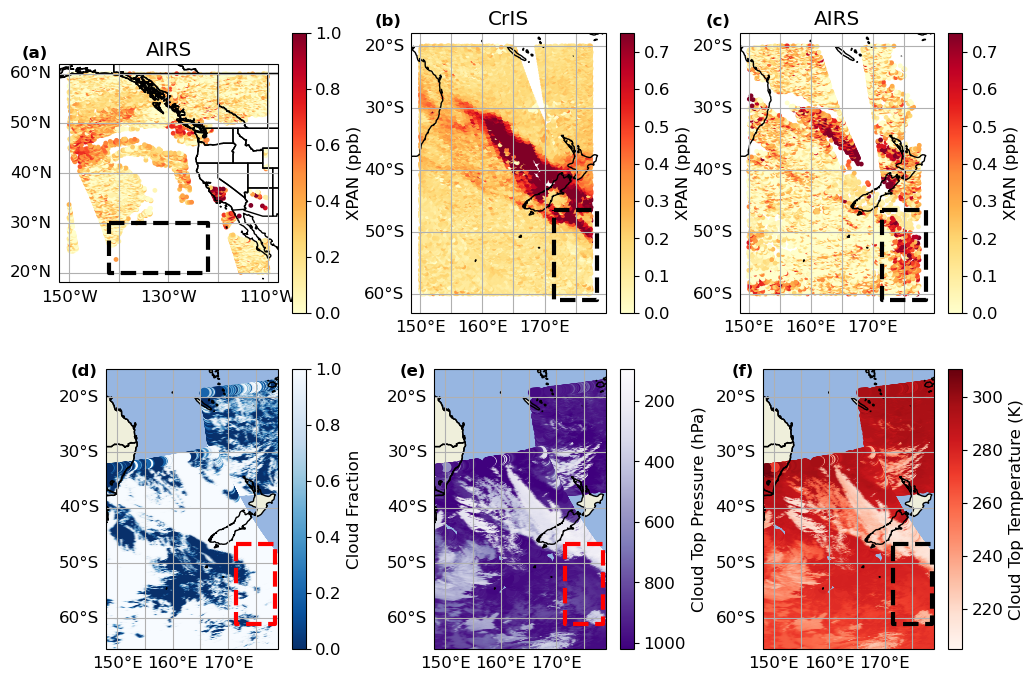

In [79]:
with plt.rc_context({'font.size': 12}):
    _, axs = plt.subplots(2, 3, figsize=(12,8), subplot_kw={'projection': ccrs.PlateCarree()})

    ax = axs[0,0]
    airs_qual_filter_withpca = make_airs_filterer(quality.PCALowCloudPANFilterer(), include_h2o=False)
    quick_plots.plot_sounding_map_from_combined(
        '../static-data/validation/airs-runs/airs/2020-09-11/combine/West_Coast_Fires_Pacific/Lite_Products_L2-PAN-0.nc',
        variable='Retrieval/XPAN800',
        map_features=[cfeat.COASTLINE, cfeat.STATES],
        filterer=airs_qual_filter_withpca,
        ax=ax,
        cblabel='XPAN (ppb)',
        cmap='YlOrRd',
        vmax=1
    )

    plot_box(*cloud_box, ax=ax, color='k', ls='--', lw=3)
    ax.set_title('AIRS')
    
    ax = axs[0,1]
    cris_qual_filter = quality.StdFlagQualityFilterer('Quality')
    quick_plots.plot_sounding_map_from_combined(
        combined_file='../static-data/validation/airs-runs/cris/2020-01-01/combine/Australian_Fires_PAN/Lite_Products_L2-PAN-0.nc',
        variable='Retrieval/XPAN800',
        map_features=[cfeat.COASTLINE],
        bias_corr=quality.CrisXpanBiasCorr(),
        filterer=cris_qual_filter,
        vmax=0.75,
        cblabel='XPAN (ppb)',
        cmap='YlOrRd',
        ax=ax
    )
    plot_box(*aus_cloud_box, ax=ax, color='k', ls='--', lw=3)
    ax.set_title('CrIS')

    ax = axs[0,2]
    quick_plots.plot_sounding_map_from_combined(
        '../static-data/validation/airs-runs/airs/2020-01-01/combine/Australian_Fires_PAN/Lite_Products_L2-PAN-0.nc',
        variable='Retrieval/XPAN800',
        map_features=[cfeat.COASTLINE],
        filterer=airs_qual_filter_withpca,
        ax=ax,
        cblabel='XPAN (ppb)',
        cmap='YlOrRd',
        vmax=0.75
    )

    plot_box(*aus_cloud_box, ax=ax, color='k', ls='--', lw=3)
    ax.set_title('AIRS')

    plot_wcf_modis(
        aus_modis_data,
        modis_cblabels={'Cloud_Top_Pressure': 'Cloud Top Pressure (hPa)', 'Cloud_Top_Temperature': 'Cloud Top Temperature (K)', 'Cloud_Fraction': 'Cloud Fraction'},
        invert_colorbar_for=['Cloud_Top_Pressure'],
        variable_plot_kws={'Cloud_Top_Pressure': {'cmap': 'Purples'}, 'Cloud_Top_Temperature': {'cmap': 'Reds'}, 'Cloud_Fraction': {'cmap': 'Blues_r', 'vmin': 0, 'vmax': 1.0}},
        axs=axs[1]
    )
    
    for iax, ax in enumerate(axs[1]):
        ax.set_extent([148, 179, -65, -15])
        color = 'k' if iax == 2 else 'r'
        plot_box(*aus_cloud_box, ax=ax, lw=3, color=color, ls='--')

    jplt.label_subplots(axs[0], seq='abc', ypos=1.025, xpos=-0.05)
    jplt.label_subplots(axs[1], seq='def', ypos=0.975, xpos=-0.05)
    plt.savefig('img/pca-filter-results.png', bbox_inches='tight')
    plt.savefig('img/pca-filter-results.pdf', bbox_inches='tight')
    

## Machine learning filter

### Utilities

In [12]:
CRIS_LABELS = {
    'c_hat_pwak_bc': 'CrIS XPAN800 (ppb, H$_2$O BC + AIRS AKs)',
    'c_hat_pwak': 'CrIS XPAN800 (ppb, AIRS AK correction)',
    'xpan_cris': 'CrIS XPAN800 (ppb, no correction)'
}

VAL_CASE_LABELS = {
    'afr-sep11': 'Africa (2020-09-11)',
    'ama-sep11': 'Amazon (2020-09-11)',
    'aus-jan05': 'Australia/NZ (2020-01-05)',
    'wcf-sep11': 'US West Coast (2020-09-11)'
}

In [13]:
from dataclasses import dataclass
from typing import Dict

@dataclass
class ModelEval:
    model: training.tree.DecisionTreeClassifier
    features: features.FeatureSet
    flagger: training.TrainingFlag
    

def add_ml_vars(df, combine_dir=None):
    if combine_dir is not None:
        keys = aread._get_test_keys_from_df(df)
        assert len(keys) == 1
        combine_dir = {keys[0]: Path(combine_dir)}
    df = aread.load_and_merge_quality_vars(df, airs_combine_dirs=combine_dir)
    return aread.load_and_merge_radiance_vars(df, airs_combine_dirs=combine_dir)


def make_truth_metric_df(model_evaluation_info: Dict[str, ModelEval], val_df_full: pd.DataFrame,
                         metric: metrics.PerformanceMetric = metrics.TruthRateMetric()):
    val_df_full = val_df_full.dropna()
    categories = ['true_good', 'true_bad', 'false_good', 'false_bad', 'overall']
    cat_labels = {k: k.replace('_', ' ').capitalize() for k in categories}
    df = pd.DataFrame(np.nan, index=cat_labels.values(), columns=model_evaluation_info.keys())
    for mkey, eval_info in model_evaluation_info.items():
        val_df = eval_info.features.subset_df(val_df_full)
        is_good_true = eval_info.flagger.make_training_flag(val_df_full).to_numpy()
        is_good_pred = eval_info.model.predict(val_df.to_numpy())
        metric_arrays = metric.index_arrays(is_good_true, is_good_pred)
        for k, arr in metric_arrays.items():
            label = cat_labels[k]
            df.loc[label, mkey] = np.sum(arr) / np.size(arr) * 100
            
        overall = 100*metric.metric(is_good_true, is_good_pred)
        df.loc[cat_labels['overall'], mkey] = overall
        
    return df

In [14]:
training_df = aread.load_xpan_dataframe(['aus-jan01', 'wcf-sep13'], apply_cris_h2o_filter=False)
aus_val_df = aread.load_xpan_dataframe(['aus-jan05'], apply_cris_h2o_filter=False)
wcf_val_df = aread.load_xpan_dataframe(['wcf-sep11'], apply_cris_h2o_filter=False)
ama_val_df = aread.load_xpan_dataframe(['ama-sep11'], apply_cris_h2o_filter=False)
afr_val_df = aread.load_xpan_dataframe(['afr-sep11'], apply_cris_h2o_filter=False)

Loading aus-jan01
Calculating XPAN800 [######################################] 50966/50966
Calculating XPAN800 [######################################] 51314/51314
NOT Including H2O-1 quality flag in CrIS filtering
CrIS has 3088 soundings before quality filtering, 3062 after
Matching AIRS to nearest CrIS [##############################] 3365/3365
Calculating c_hat values [###################################] 3365/3365

Loading wcf-sep13
Calculating XPAN800 [######################################] 34076/34076
Calculating XPAN800 [######################################] 37636/37636
NOT Including H2O-1 quality flag in CrIS filtering
CrIS has 12857 soundings before quality filtering, 12484 after
Matching AIRS to nearest CrIS [############################] 11146/11146
Calculating c_hat values [#################################] 11146/11146

Loading aus-jan05
Calculating XPAN800 [######################################] 48559/48559
Calculating XPAN800 [######################################] 

In [15]:
training_df_full = add_ml_vars(training_df)
aus_val_df_full = add_ml_vars(aus_val_df)
wcf_val_df_full = add_ml_vars(wcf_val_df)
ama_val_df_full = add_ml_vars(ama_val_df)
afr_val_df_full = add_ml_vars(afr_val_df)

combined_val_df_full = pd.concat([aus_val_df_full, wcf_val_df_full, ama_val_df_full, afr_val_df_full])

/project/lt_ref17/laughner/notebooks/pan-camel/src/airs-pan-ml/airs_pan_ml/readers.py:685: RuntimeWarning: divide by zero encountered in true_divide
  bt = RADCN2 * frequency / np.log(1 + (RADCN1 * frequency**3 / rad))


In [16]:
loose_flag_ak = metrics.TrainingFlag(max_abs_diff=0.2, max_rel_diff=0.5, op='or', cris_pan_colname='c_hat_pwak')
qual_features = features.ColnameFeatureSet([
    'ResidualNormInitial', 'ResidualNormFinal', 'RadianceMaximumSNR', 
    'KdotDL', 'LdotDL', 'PCLOUD', 'CLOUD_VAR', 'EMIS_MEAN', 'Desert_Emiss_QA',
    'H2O_H2O_Quality', 'TATM_Propagated', 'O3_Propagated', 'H2O_Propagated',
    'radianceResidualRMS', 'radianceResidualMean', 'CLOUD_MEAN',
])

In [17]:
quality_ak_no_bc_model = ModelEval(
        model=training.make_model(training_df_full, qual_features, loose_flag_ak),
        features=qual_features,
        flagger=loose_flag_ak
    )

### Correlation plots

In [30]:
def plot_box_mean_correlation(model_eval: ModelEval, val_df_full: pd.DataFrame, cris_column: str, box_size: float,
                              extra_qual_fxn=None, with_err=True, min_count=1, ax=None):
    if model_eval is not None:
        is_good_predict = training.model_prediction(
            model=model_eval.model,
            val_df_full=val_df_full,
            features=model_eval.features
        )
    else:
        is_good_predict = np.ones(val_df_full.shape[0], dtype=bool)

    if extra_qual_fxn is not None:
        is_good_predict &= extra_qual_fxn(val_df_full)

    tmp_df = val_df_full.loc[is_good_predict, ['test_key', 'lon_airs', 'lat_airs', 'xpan_airs', cris_column]].copy()
    tmp_df = assign_lat_lon_boxes(tmp_df, box_size)
    
    ax = ax or plt.gca()
    xall = []
    yall = []
    nall = []
    for key, test_df in tmp_df.groupby('test_key'):
        means = test_df.groupby(['lon_box_idx', 'lat_box_idx']).mean()
        stds = test_df.groupby(['lon_box_idx', 'lat_box_idx']).mean()
        n = test_df.groupby(['lon_box_idx', 'lat_box_idx']).count()
        nn = (n.xpan_airs >= min_count).to_numpy()

        x = means.loc[nn,cris_column].to_numpy()
        y = means.loc[nn,'xpan_airs'].to_numpy()
        label = VAL_CASE_LABELS.get(key, key)
        if with_err:
            ax.errorbar(
                x=x,
                y=y,
                xerr=stds.loc[nn,cris_column].to_numpy(),
                yerr=stds.loc[nn,'xpan_airs'].to_numpy(),
                fmt='.',
                elinewidth=0.5,
                label=label
            )
        else:
            ax.scatter(
                x=x,
                y=y,
                s=np.sqrt(n.loc[nn,'xpan_airs'].to_numpy()),
                label=label
            )
        xall.append(x)
        yall.append(y)
        nall.append(n.loc[nn,'xpan_airs'].to_numpy())

    xall = np.concatenate(xall)
    yall = np.concatenate(yall)
    nall = np.concatenate(nall)
    fit = jstats.PolyFitModel(xall, yall, model='robust', nans='drop')
    fit.plot_fit(ax, label='')
    fit_label = f'y = {fit.slope:.2f}x + {fit.yint:.2f}'
    r, _ = pearsonr(xall, yall)
    r2 = r2_score(fit(xall), yall)
    rmse = np.sqrt( np.nanmean( (yall - xall)**2 ) )
    frac_rmse = np.sqrt( np.nanmean( ( (yall-xall)/xall )**2 ) )
    full_string = f'{fit_label}\n$R = {r:.3}$\nRMSE = {rmse:.2} ppb'
    ax.text(0.95, 0.95, full_string, va='top', ha='right', transform=ax.transAxes,
            bbox=dict(facecolor='white', edgecolor='black'))

    ax.set_xlabel(CRIS_LABELS.get(cris_column, cris_column))
    ax.set_ylabel('AIRS XPAN800 (ppb)')
    return pd.DataFrame({'x': xall, 'y': yall, 'n': nall})


def assign_lat_lon_boxes(tmp_df, box_size: float):
    tmp_df['lon_box_idx'] = (tmp_df.lon_airs / box_size).round().astype(int)
    tmp_df['box_center_lon'] = tmp_df.lon_box_idx * box_size
    tmp_df['lat_box_idx'] = (tmp_df.lat_airs / box_size).round().astype(int)
    tmp_df['box_center_lat'] = tmp_df.lat_box_idx * box_size
    return tmp_df


def h2o_and_deqa_filter(val_df_full):
    return (val_df_full.H2O_Propagated == 1) & (val_df_full.Desert_Emiss_QA > 0.94)

def deqa_filter(val_df_full):
    return val_df_full.Desert_Emiss_QA > 0.94


def num_soundings_per_box_box_plot(stat_df_dict, ax=None):
    ticks = sorted(stat_df_dict.keys())
    x = [stat_df_dict[t].n.to_numpy() for t in ticks]
    ax = ax or plt.gca()
    ax.boxplot(x)
    ax.set_xticks(np.arange(1, len(ticks)+1))
    ax.set_xticklabels(ticks)
    ax.set_yscale('log')
    ax.grid(True)
    ax.set_xlabel('Box edge length (deg.)')
    ax.set_ylabel('# points per box')


def num_soundings_per_box_table(stat_df_dict):
    widths = []
    percentiles = []

    for w, df in stat_df_dict.items():
        n = df.n.to_numpy()
        widths.append(w)
        percentiles.append(np.quantile(n, [0.01, 0.25, 0.5, 0.75, 0.99]))

    return pd.DataFrame(percentiles, index=widths, columns=[
        '1st pct.', '25th pct.', 'Median', '75th pct.', '99th pct.'
    ])

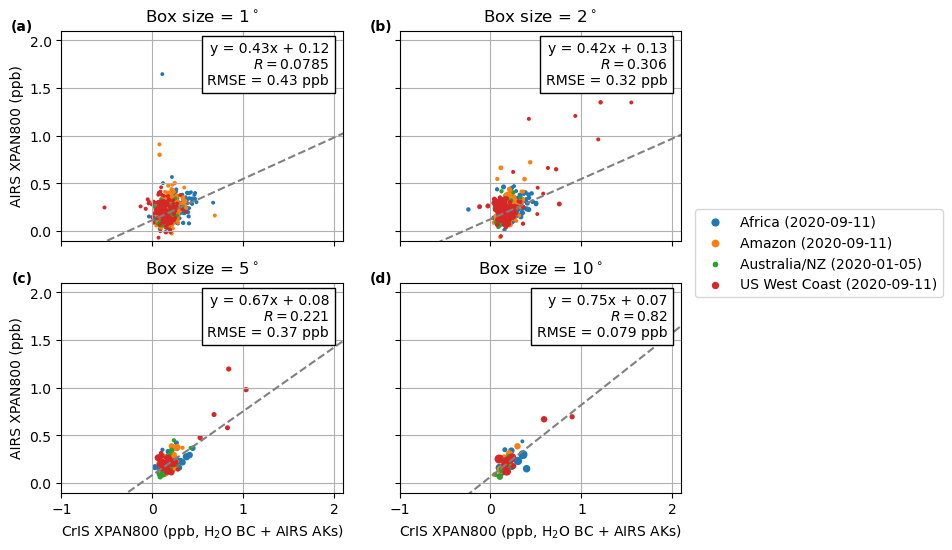

In [84]:
box_sizes = [1, 2, 5, 10]
n_boxes = len(box_sizes)
_, axs = plt.subplots(2, 2, figsize=(8, 6), sharey=True, sharex=True)
binned_points = dict()
for ax, size in zip(axs.flat, box_sizes):
    binned_points[size] = plot_box_mean_correlation(
        quality_ak_no_bc_model,
        combined_val_df_full,
        cris_column='c_hat_pwak_bc',
        box_size=size, with_err=False,
        min_count=10,
        extra_qual_fxn=deqa_filter,
        ax=ax
    )
    ax.set_title(f'Box size = {size}$^\\circ$')
    ax.grid(True)

binned_plots_xlim = (-1, 2.1)
ax.set_xlim(binned_plots_xlim)
binned_plots_ylim = (-0.1, 2.1)
ax.set_ylim(binned_plots_ylim)

ax.legend(loc='lower left', bbox_to_anchor=(1.025, 0.9))
jplt.label_subplots(axs[:,0], seq='ac', ypos=1)
jplt.label_subplots(axs[:,1], seq='bd', ypos=1, xpos=-0.025)
for ax in axs[0]:
    ax.set_xlabel('')
for ax in axs[:,1]:
    ax.set_ylabel('')
plt.savefig('img/airs-cris-correlation.pdf', bbox_inches='tight')

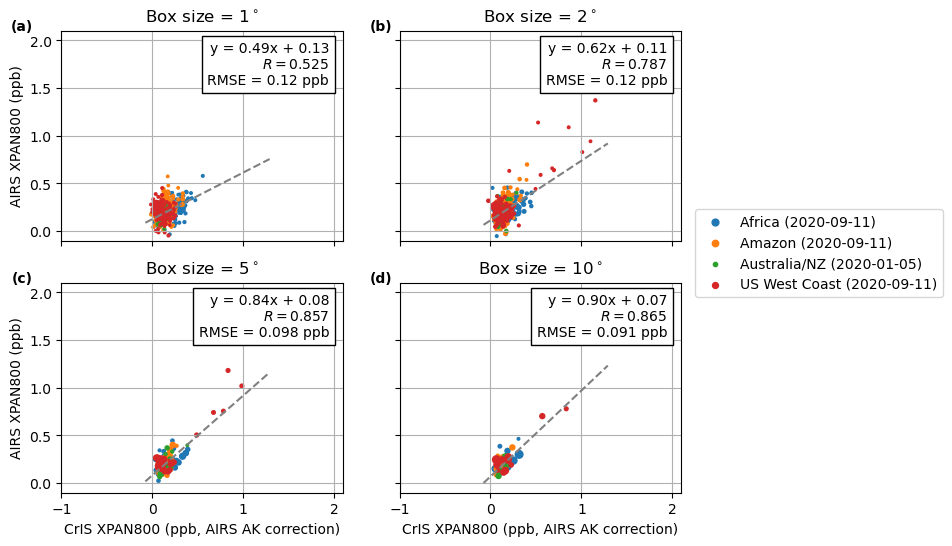

In [33]:
box_sizes = [1, 2, 5, 10]
n_boxes = len(box_sizes)
_, axs = plt.subplots(2, 2, figsize=(8, 6), sharey=True, sharex=True)
binned_points = dict()
for ax, size in zip(axs.flat, box_sizes):
    binned_points[size] = plot_box_mean_correlation(
        quality_ak_no_bc_model,
        combined_val_df_full,
        cris_column='c_hat_pwak',
        box_size=size, with_err=False,
        min_count=10,
        extra_qual_fxn=deqa_filter,
        ax=ax
    )
    ax.set_title(f'Box size = {size}$^\\circ$')
    ax.grid(True)

binned_plots_xlim = (-1, 2.1)
ax.set_xlim(binned_plots_xlim)
binned_plots_ylim = (-0.1, 2.1)
ax.set_ylim(binned_plots_ylim)

ax.legend(loc='lower left', bbox_to_anchor=(1.025, 0.9))
jplt.label_subplots(axs[:,0], seq='ac', ypos=1)
jplt.label_subplots(axs[:,1], seq='bd', ypos=1, xpos=-0.025)
for ax in axs[0]:
    ax.set_xlabel('')
for ax in axs[:,1]:
    ax.set_ylabel('')


In [49]:
# Check how many points are off the axes for each panel
for size, stat_df in binned_points.items():
    n = np.sum( (stat_df.x < binned_plots_xlim[0]) | (stat_df.x > binned_plots_xlim[1]) | (stat_df.y < binned_plots_ylim[0]) | (stat_df.y > binned_plots_ylim[1]) )
    print(size, n, stat_df.shape[0])

1 1 844
2 1 508
5 1 140
10 0 51


In [80]:
print(num_soundings_per_box_table(binned_points).to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &  1st pct. &  25th pct. &  Median &  75th pct. &  99th pct. \\
\midrule
1  &      10.0 &      11.00 &    14.0 &      18.00 &      41.57 \\
2  &      10.0 &      20.00 &    33.0 &      46.25 &     125.79 \\
5  &      12.0 &      47.75 &    96.0 &     203.50 &     621.71 \\
10 &      11.5 &      93.50 &   257.0 &     529.50 &    1663.00 \\
\bottomrule
\end{tabular}



In [40]:
def plot_single_sounding_correlation(model_eval: ModelEval, val_df_full: pd.DataFrame, cris_column: str,
                                     extra_qual_fxn=None, extent=None, ax=None):
    if model_eval is not None:
        is_good_predict = training.model_prediction(
            model=model_eval.model,
            val_df_full=val_df_full,
            features=model_eval.features
        )
    else:
        is_good_predict = np.ones(val_df_full.shape[0], dtype=bool)

    if extra_qual_fxn is not None:
        is_good_predict &= extra_qual_fxn(val_df_full)

    x = val_df_full.loc[is_good_predict, cris_column].to_numpy()
    y = val_df_full.loc[is_good_predict, 'xpan_airs'].to_numpy()
    ax = ax or plt.gca()
    h = ax.hexbin(x, y, mincnt=1, bins='log', cmap='PuBu', extent=extent)
    plt.colorbar(h, ax=ax, label='# soundings')
    ax.grid(True)
    ax.set_xlabel(CRIS_LABELS.get(cris_column, cris_column))
    ax.set_ylabel('AIRS XPAN800 (ppb)')

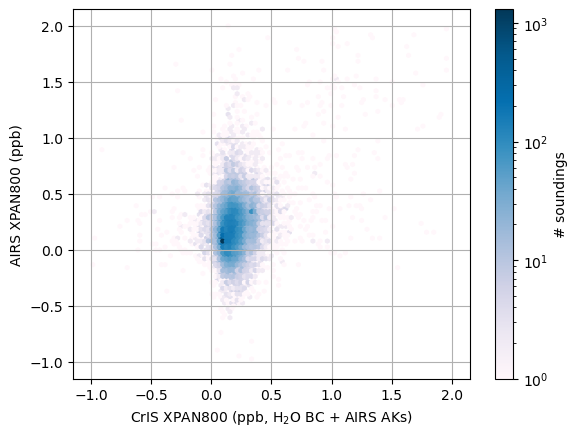

In [43]:
plot_single_sounding_correlation(
    quality_ak_no_bc_model,
    combined_val_df_full,
    'c_hat_pwak_bc',
    extra_qual_fxn=deqa_filter,
    extent=[-1, 2, -1, 2]
)
plt.savefig('img/single-sounding-corr.png', bbox_inches='tight')
plt.savefig('img/single-sounding-corr.pdf', bbox_inches='tight')


### African desert

In [93]:
def plot_single_sounding_map(val_df_full: pd.DataFrame, xpan_column: str, model_eval: ModelEval, test_key: str, extra_qual_fxn=None,
                             use_cris_coords=False, ax=None, clabel=None, add_states=False, **scatter_kws):
    kk = val_df_full.test_key == test_key
    plot_df = _map_df_prep(val_df_full.loc[kk,:], model_eval, box_size=None, extra_qual_fxn=extra_qual_fxn)
    if ax is None:
        _, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

    scatter_kws.setdefault('s', 1)
    if use_cris_coords:
        lon = plot_df.lon_cris
        lat = plot_df.lat_cris
    else:
        lon = plot_df.lon_airs
        lat = plot_df.lat_airs
    h = ax.scatter(lon, lat, c=plot_df[xpan_column], **scatter_kws)
    plt.colorbar(h, ax=ax, label=clabel or xpan_column)
    gl = ax.gridlines(draw_labels=True)
    gl.right_labels=False
    gl.top_labels=False
    ax.coastlines()
    ax.add_feature(cfeat.BORDERS)
    if add_states:
        ax.add_feature(cfeat.STATES)


def _map_df_prep(val_df_full, model_eval, box_size, extra_qual_fxn):
    if model_eval is not None:
        is_good_predict = training.model_prediction(
            model=model_eval.model,
            val_df_full=val_df_full,
            features=model_eval.features
        )
    else:
        is_good_predict = np.ones(val_df_full.shape[0], dtype=bool)
        
    if extra_qual_fxn is not None:
        is_good_predict &= extra_qual_fxn(val_df_full)

    val_df_full = val_df_full.loc[is_good_predict, :].copy()
    if box_size is not None:
        return assign_lat_lon_boxes(val_df_full, box_size=box_size)
    else:
        return val_df_full
    

def plot_camel_emissivity_in_box(l2_file, extent, color='black', include_spread=True, ax=None, **plot_kws):
    freq_grid, emis = _get_hsr_emissivity(l2_file, extent)

    if np.all(np.isnan(emis)):
        print('emis is all NaNs!')
    
    mean_emis = np.nanmean(emis, axis=0)
    std_emis = np.nanstd(emis, axis=0, ddof=1)
    upper_emis = mean_emis + std_emis
    lower_emis = mean_emis - std_emis

    ax = ax or plt.gca()
    ax.plot(freq_grid, mean_emis, color=color, **plot_kws)
    if include_spread:
        ax.fill_between(freq_grid, lower_emis, upper_emis, alpha=0.25, color=color)
    ax.set_xlabel('Frequency (cm$^{-1}$)')
    ax.set_ylabel('Emissivity (unitless)')
    ax.grid(True)

def _get_hsr_emissivity(l2_file, extent, return_original=False):
    with Dataset(l2_file) as ds:
        lon = readers.get_nc_var(ds, 'Longitude')
        lat = readers.get_nc_var(ds, 'Latitude')
        emissivity = readers.get_nc_var(ds, 'Characterization/Native_HSR_Emissivity_Initial')
        freq_grid = readers.get_nc_var(ds, 'Characterization/Native_HSR_Emis_Wavenumber')

    # The emissivity and its frequency grid are padded with fill values, so make sure
    # that the padding is consistent within our extent, and that the frequency grid is
    # as well
    lonmin, lonmax, latmin, latmax = extent
    xx = (lon >= lonmin) & (lon <= lonmax)
    yy = (lat >= latmin) & (lat <= latmax)
    emissivity = emissivity[xx & yy, :]
    freq_grid = freq_grid[xx & yy, :]
    freq_grid_out, emissivity_out = _interp_to_common_grid(freq_grid, emissivity)

    if return_original:
        return freq_grid_out, emissivity_out, freq_grid, emissivity
    else:
        return freq_grid_out, emissivity_out


def _interp_to_common_grid(freq, emis):
    unique_freq = np.unique(freq[freq > -990])
    n_soundings = emis.shape[0]
    n_freq = unique_freq.size
    emis_out = np.full([n_soundings, n_freq], np.nan)

    for i, (this_freq, this_emis) in tqdm(enumerate(zip(freq, emis))):
        xx = this_freq > -990
        if not np.any(xx):
            continue
        assert np.array_equal(xx, this_emis > -990)
        f = interp1d(this_freq[xx], this_emis[xx], bounds_error=False)
        emis_out[i] = f(unique_freq)

    return unique_freq, emis_out


def add_spectral_feature(specie, ax=None, spectral_signature_file='extra-data/spectral-signatures.nc', **style):
    with Dataset(spectral_signature_file) as ds:
        freq = ds['frequency'][:].filled(np.nan)
        bt = ds[f'{specie}_delta_brightness_temperature'][:].filled(np.nan)

    ax = ax or plt.gca()
    ax.plot(freq, bt, **style)

3869it [00:00, 13699.44it/s]
2047it [00:00, 13570.20it/s]
3869it [00:00, 13571.82it/s]
2047it [00:00, 13672.76it/s]


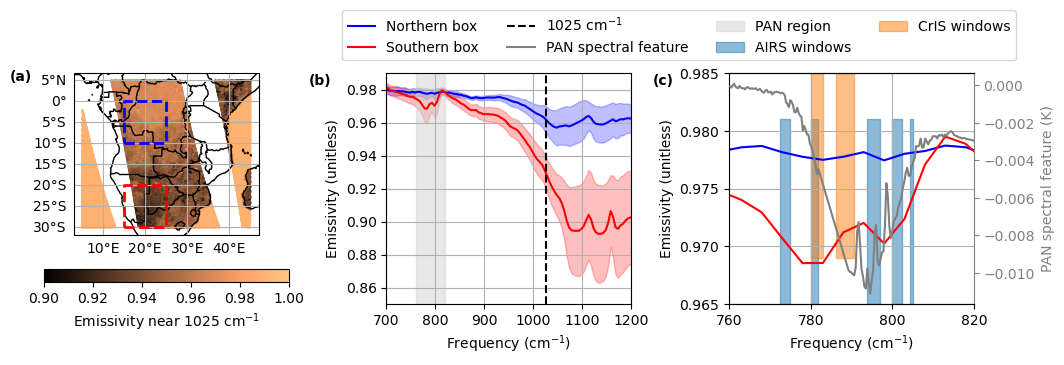

In [124]:
northern_box = [15, 25, -10, 0]
southern_box = [15, 25, -30, -20]
pan_window = [760, 820]
fig = plt.figure(figsize=(12,3))
all_axs = []
ax = fig.add_subplot(1,3,1,projection=ccrs.PlateCarree())
all_axs.append(ax)
quick_plots.plot_sounding_map_from_combined(
    combined_file='../static-data/validation/airs-runs/airs/2020-09-11/combine/African_Fires_PAN/Products_L2-PAN-0.nc',
    variable='Characterization/Desert_Emiss_QA',
    map_features=[cfeat.COASTLINE, cfeat.BORDERS],
    cblabel='Emissivity near 1025 cm$^{-1}$',
    s=1, cmap='copper', vmin=0.9, vmax=1.0,
    cb_kws={'orientation': 'horizontal'},
    ax=ax
)
plot_box(*northern_box, ax=ax, color='blue', ls='--', lw=2)
plot_box(*southern_box, ax=ax, color='red', ls='--', lw=2)

ax = fig.add_subplot(1,3,2)
all_axs.append(ax)
plot_camel_emissivity_in_box(
    l2_file='../static-data/validation/airs-runs/airs/2020-09-11/combine/African_Fires_PAN/Products_L2-PAN-0.nc',
    extent=northern_box,
    label='Northern box',
    color='blue',
    ax=ax
)

plot_camel_emissivity_in_box(
    l2_file='../static-data/validation/airs-runs/airs/2020-09-11/combine/African_Fires_PAN/Products_L2-PAN-0.nc',
    extent=southern_box,
    label='Southern box',
    color='red',
    ax=ax
)

# ax.axvline(795, color='gray', ls='-.', label='PAN feature center')
h_pan = ax.fill_betweenx([0.8, 1.0], *pan_window, color='lightgray', alpha=0.5, label='PAN region')
ax.axvline(1025, color='black', ls='--', label='1025 cm$^{-1}$')
ax.set_xlim(700, 1200)
ax.set_ylim(0.85, 0.99)
plt.subplots_adjust(wspace=0.33)


ax = fig.add_subplot(1,3,3)
all_axs.append(ax)
plot_camel_emissivity_in_box(
    l2_file='../static-data/validation/airs-runs/airs/2020-09-11/combine/African_Fires_PAN/Products_L2-PAN-0.nc',
    extent=northern_box,
    label='Northern box',
    include_spread=False,
    color='blue',
    ax=ax
)

plot_camel_emissivity_in_box(
    l2_file='../static-data/validation/airs-runs/airs/2020-09-11/combine/African_Fires_PAN/Products_L2-PAN-0.nc',
    extent=southern_box,
    label='Southern box',
    include_spread=False,
    color='red',
    ax=ax
)

_, _, ax2 = jplt.create_twin_axes_with_color(color2='gray', ax=ax)
add_spectral_feature('pan', ax=ax2, color='gray')
ax2.set_ylabel('PAN spectral feature (K)')
ax.set_xlim(*pan_window)
ax.set_ylim(0.965, 0.985)
h_airs = _plot_windows(AIRS_WINDOWS, ax=ax, half='top-offset', color='tab:blue', label='AIRS windows')
h_cris = _plot_windows(CRIS_WINDOWS, ax=ax, half='bottom-offset', color='tab:orange', label='CrIS windows')

handles = [
    Line2D([0], [0], color='blue', label='Northern box'),
    Line2D([0], [0], color='red', label='Southern box'),
    Line2D([0], [0], color='black', ls='--', label='1025 cm$^{-1}$'),
    Line2D([0], [0], color='gray', label='PAN spectral feature'),
    h_pan,
    h_airs,
    h_cris,
]
ax.legend(handles=handles, loc='lower right', ncol=4, bbox_to_anchor=(1.2, 1.025))

plt.subplots_adjust(wspace=0.4)
jplt.label_subplots(all_axs, xpos=-0.225)
plt.savefig('img/desert-emiss-explanation.png', bbox_inches='tight')
plt.savefig('img/desert-emiss-explanation.pdf', bbox_inches='tight')

**TODO:** overplot PAN feature and CrIS windows on the emissivity spectra zoomed in on the PAN windows - mark AIRS and CrIS windows to explain why the two have opposite responses to the emissivity feature.

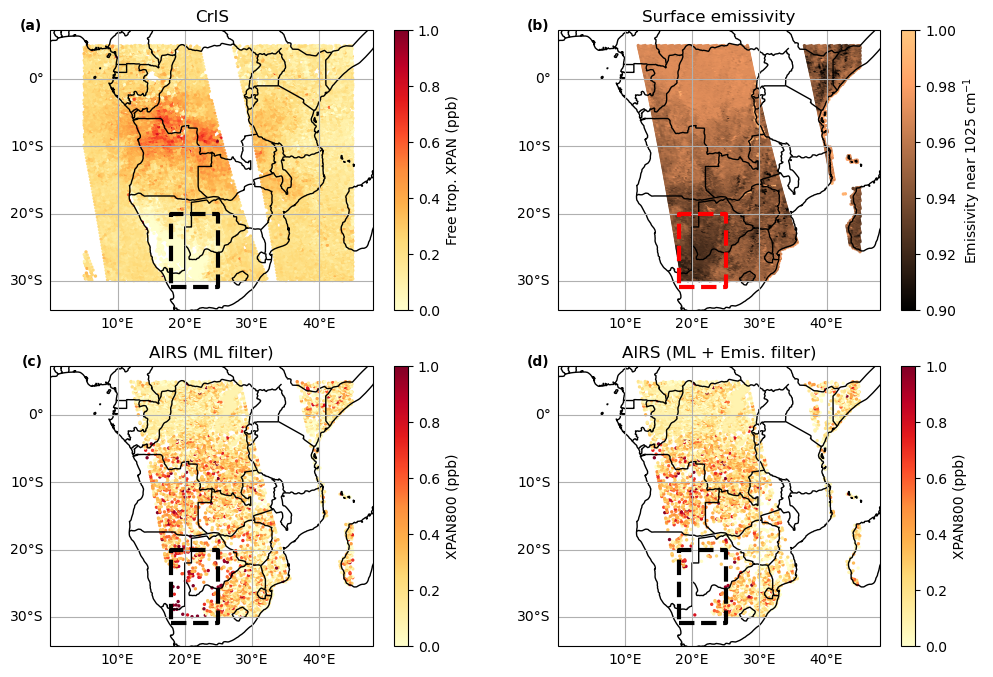

In [81]:
_, axs = plt.subplots(2, 2, figsize=(12,8), subplot_kw={'projection': ccrs.PlateCarree()}, gridspec_kw={'wspace': 0.20})

ax = axs[0,0]
cris_qual_filter = quality.StdFlagQualityFilterer('Quality')
quick_plots.plot_sounding_map_from_combined(
    combined_file='../static-data/validation/airs-runs/cris/2020-09-11/combine/African_Fires_PAN/Lite_Products_L2-PAN-0.nc',
    variable='Retrieval/XPAN800',
    map_features=[cfeat.COASTLINE, cfeat.BORDERS],
    bias_corr=quality.CrisXpanBiasCorr(),
    filterer=cris_qual_filter,
    vmin=0, vmax=1, s=2,
    cblabel='Free trop. XPAN (ppb)',
    cmap='YlOrRd',
    ax=ax
)
ax.set_title('CrIS')

ax = axs[1,0]
plot_single_sounding_map(
    combined_val_df_full,
    'xpan_airs',
    quality_ak_no_bc_model,
    test_key='afr-sep11',
    extra_qual_fxn=None,
    clabel='XPAN800 (ppb)',
    use_cris_coords=False,
    vmin=0, vmax=1, s=2, ax=ax,
    cmap='YlOrRd'
)
ax.set_title('AIRS (ML filter)')

ax = axs[1,1]
plot_single_sounding_map(
    combined_val_df_full,
    'xpan_airs',
    quality_ak_no_bc_model,
    test_key='afr-sep11',
    extra_qual_fxn=deqa_filter,
    clabel='XPAN800 (ppb)',
    use_cris_coords=False,
    vmin=0, vmax=1, s=2, ax=ax,
    cmap='YlOrRd'
)
ax.set_title('AIRS (ML + Emis. filter)')

ax = axs[0,1]
plot_single_sounding_map(
    combined_val_df_full,
    'Desert_Emiss_QA',
    model_eval=None,
    test_key='afr-sep11',
    extra_qual_fxn=None,
    clabel='Emissivity near 1025 cm$^{-1}$',
    cmap='copper',
    vmin=0.9, vmax=1, s=2, ax=ax
)
ax.set_title('Surface emissivity')
for iax, ax in enumerate(axs.flat):
    ax.set_extent([0, 48, -32, 7])
    plot_box(18, 25, -31, -20, ax=ax, ls='--', color='r' if iax == 1 else 'k', lw=3)
jplt.label_subplots(axs.flatten(), xpos=-0.025, ypos=1)

plt.savefig('img/africa-emis-filter.png', bbox_inches='tight')
plt.savefig('img/africa-emis-filter.pdf', bbox_inches='tight')


### Overall maps

In [63]:
def plot_pan_co_maps(combined_val_df_full, ml_filter, test_keys=None):
    if test_keys is None:
        test_keys = combined_val_df_full.test_key.unique()
    ny = len(test_keys)
    _, axs = plt.subplots(ny, 3, figsize=(12,3*ny), subplot_kw={'projection': ccrs.PlateCarree()}, gridspec_kw={'wspace': 0.33, 'hspace': 0.33})

    for test_key, ax_row in zip(test_keys, axs):
        plot_pan_co_map_row(test_key, combined_val_df_full, ml_filter, axs=ax_row)

def plot_pan_co_map_row(test_key, combined_val_df_full, ml_filter, axs=None):
    if axs is None:
        _, axs = plt.subplots(1, 3, figsize=(12,3), subplot_kw={'projection': ccrs.PlateCarree()}, gridspec_kw={'wspace': 0.33})
    elif len(axs) != 3:
        raise ValueError('axs must have 3 elements')

    cris_path = _path_from_test_key(test_key, 'cris')
    airs_path = _path_from_test_key(test_key, 'airs')
    map_features = [cfeat.COASTLINE, cfeat.BORDERS]
    add_states = False
    if test_key.startswith('wcf'):
        map_features.append(cfeat.STATES)
        add_states = True

    ax = axs[0]
    qual_filter = quality.StdFlagQualityFilterer('Quality')
    quick_plots.plot_sounding_map_from_combined(
        combined_file=cris_path / 'Lite_Products_L2-PAN-0.nc',
        variable='Retrieval/XPAN800',
        map_features=map_features,
        bias_corr=quality.CrisXpanBiasCorr(),
        filterer=qual_filter,
        vmin=0, vmax=1, s=2,
        cblabel='Free trop. XPAN (ppb)',
        cmap='YlOrRd',
        ax=ax
    )
    ax.set_title('CrIS')

    ax = axs[1]
    plot_single_sounding_map(
        combined_val_df_full,
        'xpan_airs',
        ml_filter,
        test_key=test_key,
        extra_qual_fxn=deqa_filter,
        clabel='XPAN800 (ppb)',
        use_cris_coords=False,
        add_states=add_states,
        vmin=0, vmax=1, s=2, ax=ax,
        cmap='YlOrRd'
    )
    ax.set_title('AIRS PAN')

    ax = axs[2]
    quick_plots.plot_sounding_map_from_combined(
        combined_file=airs_path / 'Lite_Products_L2-CO-0.nc',
        variable='Retrieval/Column',
        dim2_idx=0,
        map_features=map_features,
        bias_corr=quality.CrisXpanBiasCorr(),
        filterer=qual_filter,
        vmin=0, vmax=1e19, s=2,
        cblabel='CO total col. (molec. cm$^{-2}$)',
        cmap=cmr.gem,
        ax=ax
    )
    ax.set_title('AIRS CO')

def _path_from_test_key(test_key, instr, root='../static-data/validation/airs-runs/'):
    profile_map = {
        'aus': 'Australian_Fires_PAN',
        'wcf': 'West_Coast_Fires_Pacific',
        'ama': 'Amazon_Fires_PAN',
        'afr': 'African_Fires_PAN'
    }
    date = _date_from_test_key(test_key)
    profile = profile_map[test_key.split('-')[0]]
    return Path(root) / instr / date.strftime('%Y-%m-%d') / 'combine' / profile

def _date_from_test_key(test_key):
    tmp = pd.to_datetime(test_key.split('-', maxsplit=1)[1], format='%b%d')
    return pd.Timestamp(2020, tmp.month, tmp.day)

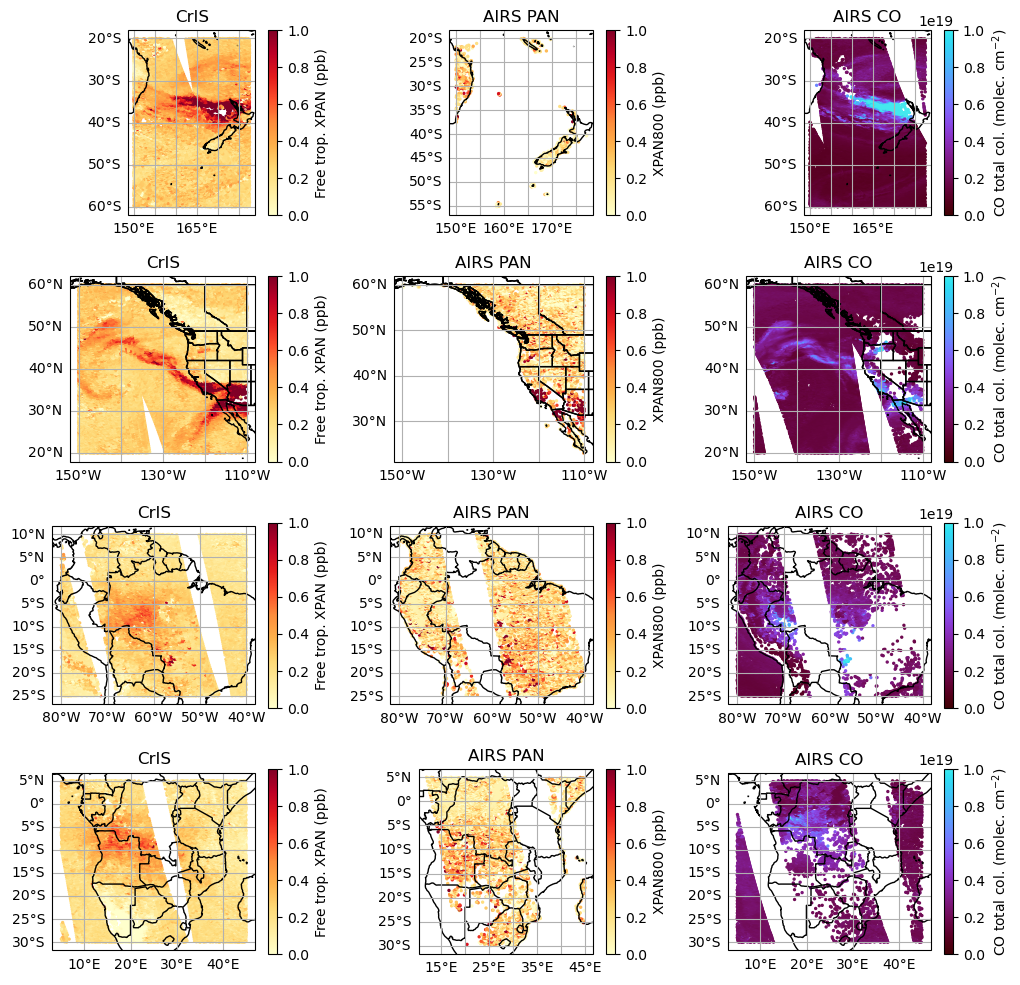

In [65]:
plot_pan_co_maps(combined_val_df_full, quality_ak_no_bc_model)
plt.savefig('img/pan-co-maps.png', bbox_inches='tight')
plt.savefig('img/pan-co-maps.pdf', bbox_inches='tight')


### Explainable AI

In [18]:
FEATURE_DISPLAY_NAMES = {
    'ResidualNormInitial': 'Res. Norm. Init.',
    'ResidualNormFinal': 'Res. Norm. Final',
    'RadianceMaximumSNR': 'Rad. Max. SNR',
    'KdotDL': 'K $\\cdot$ dL',
    'LdotDL': 'L $\\cdot$ dL',
    'PCLOUD': 'Cld. pres.',
    'CLOUD_VAR': 'Cld. OD var.',
    'EMIS_MEAN': 'Mean surf. emis.',
    'Desert_Emiss_QA': 'Desert emis.',
    'H2O_H2O_Quality': 'H$_2$O self corr.',
    'TATM_Propagated': 'Atm. T quality',
    'O3_Propagated': 'O$_3$ quality',
    'H2O_Propagated': 'H$_2$O quality',
    'radianceResidualRMS': 'Rad. resid. std. dev.',
    'radianceResidualMean': 'Rad. resid. mean',
    'CLOUD_MEAN': 'Cld. OD mean'
}

def make_shapely_values(training_df_full, model_eval_obj, expl_fraction=0.1):
    X = model_eval_obj.features.subset_df(training_df_full)
    n_expl = int(X.shape[0] * expl_fraction)
    X_expl = shap.utils.sample(X, n_expl).to_numpy()
    explainer = shap.Explainer(model_eval_obj.model.predict, X_expl)
    shap_values = explainer(X.to_numpy())
    print('X', X.shape)
    print('X_expl', X_expl.shape)
    print('shap_values', shap_values.values.shape)
    return shap_values


def assign_shapely_feature_names(shap_values: shap.Explanation, model_eval_obj):
    shap_values = deepcopy(shap_values)
    names = [FEATURE_DISPLAY_NAMES[k] for k in model_eval_obj.features.colnames]
    shap_values.feature_names = names
    return shap_values

In [19]:
shap_values = make_shapely_values(training_df_full, quality_ak_no_bc_model)

PermutationExplainer explainer: 14512it [02:56, 78.77it/s]                                                                                                                                                                             


X (14511, 16)
X_expl (1451, 16)
shap_values (14511, 16)


In [22]:
named_shap_values = assign_shapely_feature_names(shap_values, quality_ak_no_bc_model)

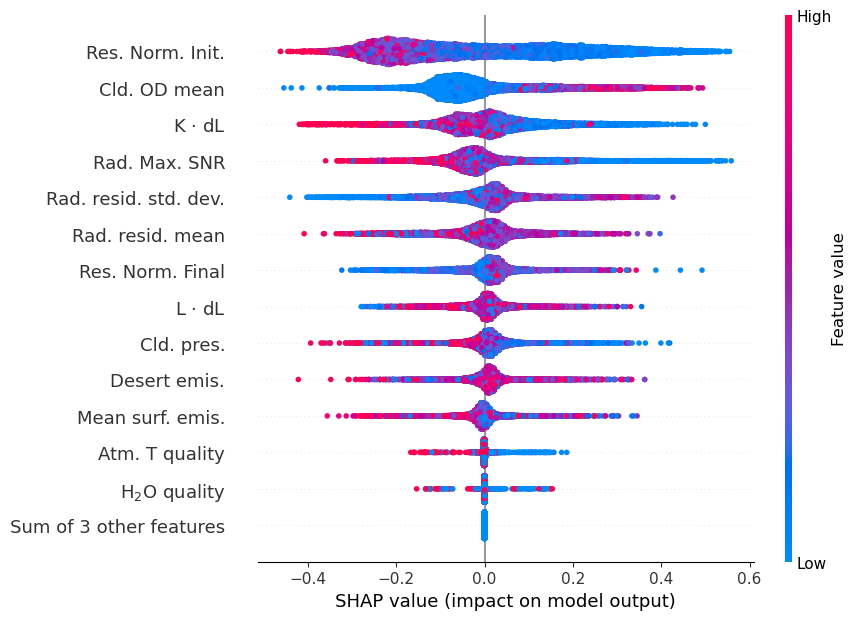

In [23]:
shap.plots.beeswarm(named_shap_values, max_display=14, show=False)
plt.savefig('img/ml-beeswarm.png', bbox_inches='tight')
plt.savefig('img/ml-beeswarm.pdf', bbox_inches='tight')

## AIRS to CrIS noise comparison

In [140]:
def load_nesr(rad_file, case=None):
    with Dataset(rad_file) as ds:
        freq = aread._get_nc_var(ds, 'FREQUENCY')
        rad = aread._get_nc_var(ds, 'RADIANCEOBSERVED')
        nesr = aread._get_nc_var(ds, 'NESR')

    arrs = {
        'freq': xr.DataArray(freq, dims=['sounding', 'channel']),
        'rad': xr.DataArray(rad, dims=['sounding', 'channel']),
        'nesr': xr.DataArray(nesr, dims=['sounding', 'channel']),
    }
    if case is not None:
        arrs['case'] = xr.DataArray([case]*freq.shape[0], dims=['sounding'])
    return xr.Dataset(arrs)


def load_nesr_many_cases(cases=('aus-jan01', 'aus-jan05', 'wcf-sep11', 'wcf-sep13', 'ama-sep11', 'afr-sep11')):
    airs_test_paths = aread.test_cases_by_key('airs')
    cris_test_paths = aread.test_cases_by_key('cris')
    airs_dsets = []
    cris_dsets = []
    for key in cases:
        print(f'Loading {key}')
        airs_path = airs_test_paths[key] / 'Products_Radiance-PAN.nc'
        cris_path = cris_test_paths[key] / 'Products_Radiance-PAN.nc'
        airs_dsets.append(load_nesr(airs_path, case=key))
        cris_dsets.append(load_nesr(cris_path, case=key))

    airs_ds = xr.concat(airs_dsets, dim='sounding')
    cris_ds = xr.concat(cris_dsets, dim='sounding')
    return airs_ds, cris_ds


def plot_nesr_median_and_quantiles(nesr_dset, instrument, relative=False, quantile_range=0.25, color='tab:blue', quantile_color=None, ax=None):
    ax = ax or plt.gca()
    freq = nesr_dset.freq.median(dim='sounding')
    if relative:
        noise = nesr_dset.nesr / nesr_dset.rad * 100
        ylabel = 'NESR as percent of radiance'
    else:
        noise = nesr_dset.nesr
        ylabel = 'NESR (K)'
    med = noise.median(dim='sounding')
    quants = noise.quantile([0.5 - quantile_range, 0.5+quantile_range], dim='sounding')
    errors = np.abs(quants - med)
    
    p1 = int((0.5 - quantile_range)*100)
    p2 = int((0.5 + quantile_range)*100)
    ax.errorbar(freq, med, yerr=errors, ls='none', color=quantile_color or color, label=f'{instrument} {p1}th-{p2}th percentile')
    ax.plot(freq, med, marker='.', ls='none', color=color, label=f'{instrument} median')
    ax.set_xlabel('Frequency (cm$^{-1}$)')
    ax.set_ylabel(ylabel)


def compute_median_noise_ratio(airs_nesr_dset, cris_nesr_dset):
    median_airs = airs_nesr_dset.nesr.median().item()
    median_cris = cris_nesr_dset.nesr.median().item()
    return median_airs / median_cris

In [133]:
airs_nesr_dset, cris_nesr_dset = load_nesr_many_cases()

Loading aus-jan01
Loading aus-jan05
Loading wcf-sep11
Loading wcf-sep13
Loading ama-sep11
Loading afr-sep11


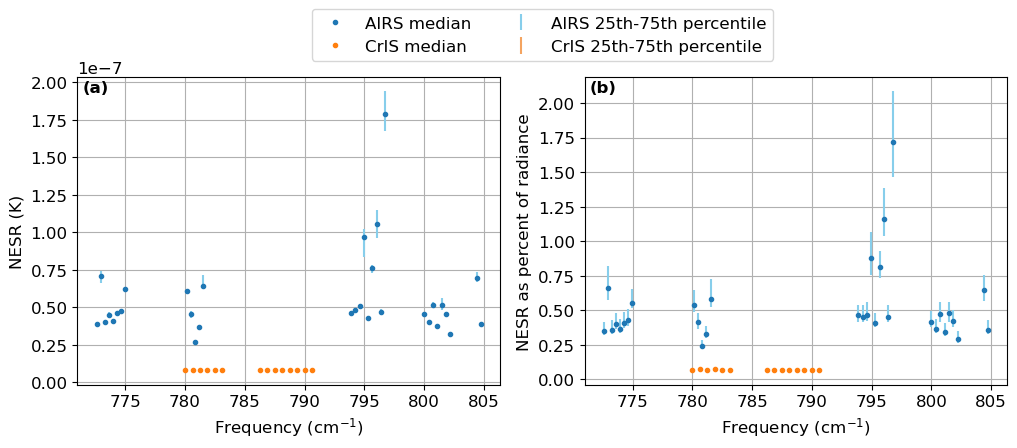

In [149]:
with plt.rc_context({'font.size': 12}):
    _, axs = plt.subplots(1,2,figsize=(12,4))
    ax = axs[0]
    plot_nesr_median_and_quantiles(airs_nesr_dset, 'AIRS', relative=False, color='tab:blue', quantile_color='skyblue', ax=ax)
    plot_nesr_median_and_quantiles(cris_nesr_dset, 'CrIS', relative=False, color='tab:orange', quantile_color='sandybrown', ax=ax)
    ax.grid(True)
    ax.legend(loc='lower center', bbox_to_anchor=(1.1, 1.025), ncol=2)

    ax = axs[1]
    plot_nesr_median_and_quantiles(airs_nesr_dset, 'AIRS', relative=True, color='tab:blue', quantile_color='skyblue', ax=ax)
    plot_nesr_median_and_quantiles(cris_nesr_dset, 'CrIS', relative=True, color='tab:orange', quantile_color='sandybrown', ax=ax)
    ax.grid(True)

    jplt.label_subplots(axs, xpos=0.075)
    
    plt.savefig('img/airs-cris-noise-comparison.pdf', bbox_inches='tight')
    

In [139]:
compute_median_noise_ratio(airs_nesr_dset, cris_nesr_dset)

5.908359858782257

In [151]:
def plot_oe_uncertainty_hist(uncert_nc_file, instrument, color='tab:blue', median_color=None, ax=None):
    ax = ax or plt.gca()
    ds = xr.open_dataset(uncert_nc_file)
    ax.hist(ds.xcol_err * 1e9, bins=100, histtype='step', color=color, label=instrument)
    med_err = ds.xcol_err.median().item() * 1e9
    ax.axvline(med_err, ls='--', color=median_color or color, label=f'{instrument} median ({med_err:.2f} ppb)')
    ax.set_xlabel(r'$X_\mathrm{PAN}$ OE error (ppb)')
    ax.set_ylabel('# soundings')

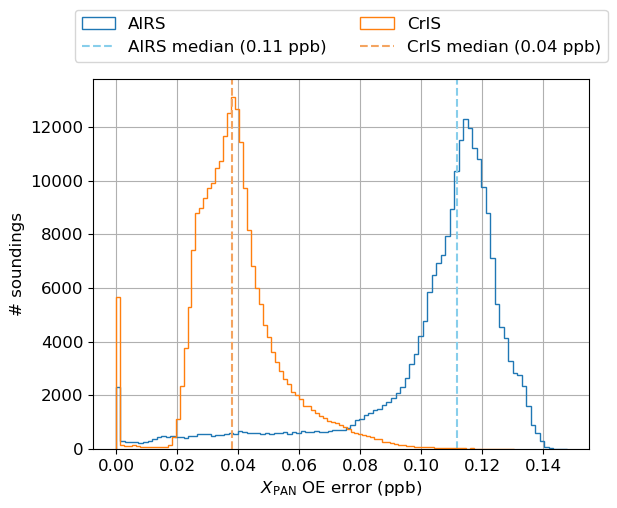

In [153]:
with plt.rc_context({'font.size': 12}):
    _, ax = plt.subplots()
    plot_oe_uncertainty_hist('extra-data/uncertainty/airs_col_error.nc', 'AIRS', color='tab:blue', median_color='skyblue', ax=ax)
    plot_oe_uncertainty_hist('extra-data/uncertainty/cris_col_error.nc', 'CrIS', color='tab:orange', median_color='sandybrown', ax=ax)
    ax.legend(ncol=2, loc='lower center', bbox_to_anchor=(0.5, 1.025))
    ax.grid(True)
    plt.savefig('img/airs-cris-obs-uncertainty.pdf', bbox_inches='tight')